# CMOS RGB image sensor

> Note: The cost of running the entire notebook is higher than 1 FlexCredit.

In this notebook, we show how to simulate optical processes in a CMOS RGB image sensor. The fundamental building blocks of the sensor are pixels, each containing microlens, color filters, and photodetector. Together, a pixel can perform multiple optical functionalities such as focusing, color filtering, and detection. Here, we illustrate how to set up the FDTD simulation and measure the performance of a typical CMOS image sensor composed of a periodic arrangement of Bayer unit cells, where we have one red (R), one blue (B), and two green (G) color filters, as shown below.

<img src="img/rgb_cmos_sensor.png" alt="Bayer Unit Cell"  width="300"/>

First, we will import Tidy3D and the other packages needed. If it is not installed, please do so with ``pip install tidy3d``. We will use the [FastDispersionFitter](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.dispersion.FastDispersionFitter.html) plugin to fit hypothetical R, G, and B step-like absorbing filter materials.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# Tidy3D imports
import tidy3d as td
from tidy3d import web
from tidy3d.plugins.dispersion import FastDispersionFitter, AdvancedFastFitterParam

## Simulation Setup
At the top of the Bayer unit cell structure, we have microlenses (silica) to focus the incoming light on the silicon photodetectors. Absorptive materials are placed below the microlenses to filter out the undesired colors at each pixel, and a metallic shield is responsible for reducing the crosstalk between neighboring unit cells. Electron-hole pairs are generated when light reaches the Si photodetector, and then the generated carriers are collected by metallic interconnections. A silicon nitride anti-reflection layer is employed to reduce the reflection losses at the silicon-silica interface. While this structure is intended to be a starting example, other color filter construction methods with improved efficiency and advanced metasurface-based color routing mechanisms are available in the literature [[1](https://www.mdpi.com/1424-8220/19/7/1536), [2](https://opg.optica.org/oe/fulltext.cfm?uri=oe-16-25-20457&id=175035), [3](https://ieeexplore.ieee.org/document/5427134), [4](https://www.nature.com/articles/s41467-022-31019-7)].

### Geometric parameters
Let's first specify all geometric parameters from the top to the bottom of the structure. Their values are not optimized. All the dimensions are in micrometers. 

In [2]:
Lx = Ly = 3.0  # Size of the Bayer unit cell along x- and y- direction.
dPML = 1.5  # PML thickness at the top of the simulation domain.

Let's consider the lens to be spherical caps (hemispheres). Since there are two by two lenses in a pixel, the diameter of the base of a cap is `Lx/2`. Once the radius is specified, the height of the cap can be computed analytically.

In [3]:
width_len = Lx/2  # Lens and color pixel width.
radius_len = 1.0 # Lens radius.

# A focal distance = R*n/(n-1)~3um is sufficient.
height_len = (1-np.cos(np.arcsin(width_len/radius_len/2)))*radius_len
print(f'The height of the lens is {height_len:.3f} microns.')

The height of the lens is 0.339 microns.


Now, we can define the remaining geometrical parameters.

In [4]:
d_len_to_filter = 0.2 # Distance from the base of the lens to the top of the filter.
t_filter = 1.0 # Filter thickness.
d_filter_to_shield = 0.5 # Distance from the base of filter to the top of metallic shields.

# Metal shields are simplified to be metallic layer with holes.
t_shield = 0.10 # Shield thickness.
radius_shield = 0.95 * width_len # Radius of hole.
d_shield_to_connect = 0.5 # Distance from the base of shield to the top of metallic interconnect.

# Metallic interconnects are assumed to be rectangular rods.
t_connect = 0.10 # Thickness.
width_connect = 0.15 #Width of each rod.
gap_connect = 0.2 #Gap between adjacent interconnection planes.
distance_connect = 1.8*width_len # Distance between the center of rods parallel to the sides of unit cell. 

d_connect_to_AR = 0.5 # Distance from the base of the interconnects to the top of the anti-reflection layer.
t_silicon = 2 # Thickness of silicon photon-detector.

We will consider the simulation in the visible spectrum of wavelength range [400, 700] nm.

In [5]:
lam_range = [0.4, 0.7]

# Central wavelength for RGB colors.
lam_blue = 0.45
lam_green = 0.55
lam_red = 0.65

### Materials

Here, we load relevant materials from Tidy3D's [material library](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/material_library.html). Typical material choice is considered: photodetector made of silicon, metallic interconnects and shields made of aluminum, an anti-reflection layer made of silicon nitride, and most other optical components made of silica.

In [6]:
SiN = td.material_library['SiN']['Horiba']
Silicon = td.material_library['aSi']['Horiba']
Silica = td.material_library['SiO2']['Palik_Lossless']
metal = td.material_library['Al']['Rakic1995']

Next, we define the color filter materials. They are usually based on dye or pigment. The materials need to be very dispersive to achieve the color filtering functionality, e.g., the material for the red color filter is strongly absorptive of the blue and the green color light but transparent to the red color light. In running broadband FDTD simulation, those dispersive materials need to be fitted to analytical dispersive models such as the Drude-Lorentz model, Pole-residue pair model, etc. You can find a detailed explanation in this [lecture](https://www.flexcompute.com/fdtd101/Lecture-5-Modeling-dispersive-material-in-FDTD). 

In this example, as a proof of principle, the color filter materials are defined artificially. In practice, many actual filter materials can provide better performance. We will use the [FastDispersionFitter](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.dispersion.FastDispersionFitter.html) plugin to fit the hypothetical R, G, and B step-like absorbing filter materials. To better fit the imaginary part of the refractive index, which is most important to describe the filter response, we will adjust `weights=(0.1, 1.9)` in `AdvancedFastFitterParam`.

In [7]:
# Advanced fitter parameters.
advanced_param = AdvancedFastFitterParam(weights=(0.1, 1.9), num_iters=200)

# Red material
fname_r = "./misc/red_eps.csv"
fitter_r = FastDispersionFitter.from_file(fname_r, skiprows=1, delimiter=",")
mat_red, _ = fitter_r.fit(max_num_poles=9, eps_inf=1.0, advanced_param=advanced_param, tolerance_rms=2e-2)


# Green material
fname_g = "./misc/green_eps.csv"
fitter_g = FastDispersionFitter.from_file(fname_g, skiprows=1, delimiter=",")
mat_green, _ = fitter_g.fit(max_num_poles=9, eps_inf=1.0, advanced_param=advanced_param, tolerance_rms=2e-2)

# Blue material
fname_b = "./misc/blue_eps.csv"
fitter_b = FastDispersionFitter.from_file(fname_b, skiprows=1, delimiter=",")
mat_blue, _ = fitter_b.fit(max_num_poles=9, eps_inf=1.0, advanced_param=advanced_param, tolerance_rms=2e-2)

Output()

11:46:20 UTC WARNING: Unable to fit with weighted RMS error under               
             'tolerance_rms' of 0.02                                            

Output()

Now, let's look at the obtained refractive indices and extinction spectra of color filter materials. It is worth mentioning that here we are fitting hypothetical materials whose dispersion is very distinct from a real one, so we have focused in obtaining a good description of the extinction coefficients in detriment of the real part of refractive indices. When considering real materials, it is usually possible to fit both real and imaginary parts of the refractive index with high accuracy.

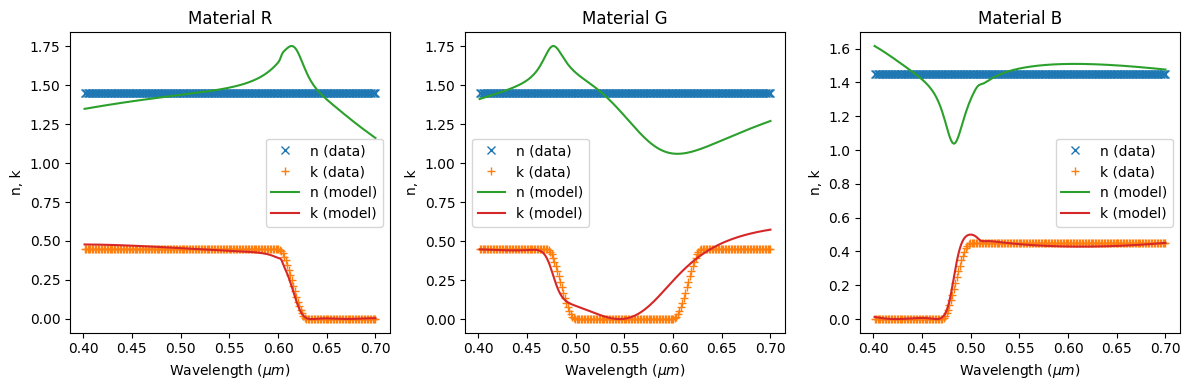

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
fitter_r.plot(mat_red, ax=ax1)
ax1.set_title("Material R")
fitter_g.plot(mat_green, ax=ax2)
ax2.set_title("Material G")
fitter_b.plot(mat_blue, ax=ax3)
ax3.set_title("Material B")
plt.show()

### Some necessary calculated parameters:

In [9]:
# Compute the thickness of anti-reflection layer so that it is reflectiveless for the green light.
n_SiN, _ = SiN.eps_complex_to_nk(SiN.eps_model(td.C_0/lam_green))
t_AR = lam_green/4/n_SiN

# Total size of computational domain along z-direction.
Lz = dPML + height_len + d_len_to_filter + t_filter + d_filter_to_shield + \
    t_shield + d_shield_to_connect + 2*t_connect + gap_connect + d_connect_to_AR + t_AR + t_silicon

# Wavelength and frequency range for Gaussian source.
freq_range = (td.C_0/lam_range[1], td.C_0/lam_range[0])
freq0 = np.mean(np.array(freq_range))
fwidth = freq0/3

# Maximum simulation runtime.
runtime = 100/fwidth

# Monitor frequency defined at the central wavelength of RGB colors.
monitor_field_freqs = td.C_0/np.array([lam_red, lam_green, lam_blue])
monitor_flux_freqs = np.linspace(td.C_0/lam_range[1], td.C_0/lam_range[0], 200)

### Structure construction
Now, we are ready to construct each component of the sensor. To build the four silica hemispherical lenses, we first create four spheres. The extra parts of the spheres can be overridden with a silica layer. 

In [10]:
# Initialize with empty list
structs = []

# Center of the sphere.
z0_len = Lz/2 - dPML - radius_len
x0_len = width_len / 2
y0_len = width_len /2

# Names of the lens structures.
len_names = ["len blue", "len red", "len green1", "len green2"]
# Signs of their x,y center positions on the Bayer unit cell.
len_sign = [[1,1], [-1,-1], [-1,1], [1, -1]]

# Now we include the lens structures.
for l_name, l_sign in zip(len_names, len_sign):
    structs.append(
        td.Structure(
            geometry=td.Sphere(
                center=(l_sign[0]*x0_len, l_sign[1]*y0_len, z0_len),
                radius=radius_len,
            ),
            medium=Silica,
            name=l_name,
        )
    )

A silica layer covers from the base of the hemispherical lens to the top of the silicon photodetector.

In [11]:
# Lower and upper boundary of the silica layer.
z_lower_silica = -Lz/2+t_silicon
z_upper_silica = Lz/2-dPML-height_len

structs.append(
    td.Structure(
        geometry=td.Box.from_bounds(
            rmin = (-td.inf,-td.inf,z_lower_silica),
            rmax = (td.inf,td.inf,z_upper_silica),
        ),
        medium=Silica,
        name='silica layer',
    )
)

Construct the Bayer color filters.

In [12]:
# Lower and upper boundary of the color filter layer.
z_upper_filter = z_upper_silica - d_len_to_filter
z_lower_filter = z_upper_filter - t_filter

ePML = 100 #um, extra length to extend into PML 

# Color filter names.
cf_names = ["blue filter", "red filter", "green1 filter", "green2 filter"]
# Color filter materials.
cf_materials = [mat_blue, mat_red, mat_green, mat_green] 
# Minimum and maximum filter bound coordinates.
cf_rmin = [[0,0], [-ePML,-ePML], [-ePML,0], [0,-ePML]]
cf_rmax = [[ePML,ePML], [0,0], [0,ePML], [ePML,0]]

# Now we include the color filter structures.
for cf_name, cf_mat, r_min, r_max in zip(cf_names, cf_materials, cf_rmin, cf_rmax):
    structs.append(
        td.Structure(
            geometry=td.Box.from_bounds(
                rmin = (r_min[0],r_min[1],z_lower_filter),
                rmax = (r_max[0],r_max[1],z_upper_filter),
            ),
            medium=cf_mat,
            name=cf_name,
        )
    )

Construct the metallic shields.

In [13]:
# A-coordinate of the center of metal shield.
z0_shield = z_lower_filter - d_filter_to_shield - t_shield/2

# First, a metallic layer:
structs.append(
   td.Structure(
       geometry=td.Box(
           size = (td.inf, td.inf, t_shield),
           center = (0,0,z0_shield),
       ),
       medium=metal,
       name='metal shield',
   )
)

# Then, make a hole:
structs.append(
   td.Structure(
       geometry=td.Cylinder(
           center = (0,0,z0_shield),
           axis = 2,
           length = t_shield,
           radius = radius_shield,
       ),
       medium=Silica,
       name='metal shield hole',
   )
)

Construct the metallic interconnects.

In [14]:
# Z-coordinate of the center of the interconnection planes.
z0_connect = z0_shield - t_shield/2 - d_shield_to_connect - t_connect/2
z1_connect = z0_connect - gap_connect  - t_connect

# Add the interconnections parallel to the sides of the unit cell.
for i in range(4):
    # Locate the the interconnections at x-, y- directions in different planes.
    zc = z0_connect if (i%2) else z1_connect

    center = [0, zc]
    center.insert(i%2, distance_connect/2 * (-1) ** (i//2))
    
    size = [td.inf,t_connect]
    size.insert(i%2, width_connect)
    structs.append(
        td.Structure(
            geometry=td.Box(
                center = center,
                size = size,
            ),
            medium=metal,
            name='interconnect ' + str(i),
        )
    )

# Add the interconnections at the center of the unit cell.
for i in range(2):
    # Locate the the interconnections at x-, y- directions in different planes.
    zc = z0_connect if (i%2) else z1_connect
    
    center = [0, 0, zc]    
    size = [td.inf, t_connect]
    size.insert(i%2, 2*width_connect)
    structs.append(
        td.Structure(
            geometry=td.Box(
                center = center,
                size = size,
            ),
            medium=metal,
            name='interconnect_ground ' + str(i),
        )
    )    

Now, we will construct the antireflection layer.

In [15]:
# z-coordinate of the center
z0_AR = z1_connect - t_connect/2 - d_connect_to_AR - t_AR/2

structs.append(
    td.Structure(
        geometry=td.Box(
            center = (0,0, z0_AR),
            size = (td.inf,td.inf,t_AR),
        ),
        medium=SiN,
        name='anti-reflection',
    )
)

And finally, we will finish the color filter structure by constructing the silicon photodetector layer.

In [16]:
# Z-coordinate of the silicon photodetector center. Add substantial thickness to extend into PML

z0_silica = -Lz/2 - ePML

structs.append(
    td.Structure(
        geometry=td.Box(
            center = (0,0, z0_silica),
            size = (td.inf,td.inf,(t_silicon+ePML)*2),
        ),
        medium=Silicon,
        name='silicon layer',
    )
)

### Boundary condition and grid setup
The pixel is periodic in `x`- and `y`- directions and is sandwiched by two absorber layers along the z-direction. Since there is a structure made of a dispersive medium extending into the absorber, we apply an adiabatic absorber instead of PML to ensure the stability of the simulation.

For spatial discretization, we apply the automatic meshing scheme where the mesh is finer inside the medium of a higher index of refraction.

In [17]:
# Boundary condition
absorber = td.Boundary.absorber()
periodic =  td.Boundary.periodic()
bspec = td.BoundarySpec(x=periodic, y=periodic, z=absorber)

# Grid specs
grid_spec = td.GridSpec.auto(min_steps_per_wvl=10, wavelength=lam_green)

### Source
For simplicity, we are using a plane wave source at normal incidence.

In [18]:
source = td.PlaneWave(
    center=(0,0,(Lz-dPML)/2),
    size=(td.inf, td.inf, 0),
    source_time = td.GaussianPulse(
        freq0=freq0,
        fwidth=fwidth,
    ),
    direction='-',
    name='planewave',
)

### Monitors

We will include field monitors to observe the field propagating from the source to the silicon photodetectors. In addition, four flux monitors will be added to calculate the pixel power at the dielectric-silicon interface. A fill factor of 50% will be used to simulate the active region area of the phototetectors.

In [19]:
monitors = []
z_silicon_top = -Lz/2+t_silicon

# Field monitor in xy plane just below antireflection layer.
monitors.append(
    td.FieldMonitor(
        center = (0, 0, -Lz/2+t_silicon-0.001),
        size = (td.inf, td.inf, 0),
        freqs = monitor_field_freqs,
        name='field_xy_silicon',
    )
)

# Field monitor in yz plane crossing the center blue and green filter.
monitors.append(
    td.FieldMonitor(
        center = (width_len/2, 0, 0),
        size = (0, td.inf, td.inf),
        freqs = monitor_field_freqs,
        name='field_yz_BG',
    )
)

# Field monitor in yz plane crossing the center red and green filter.
monitors.append(
    td.FieldMonitor(
        center = (-width_len/2, 0, 0),
        size = (0, td.inf, td.inf),
        freqs = monitor_field_freqs,
        name='field_yz_GR',
    )
)

# Photodetector flux monitors.
fmon_names = ["flux_si_blue", "flux_si_red", "flux_si_green1", "flux_si_green2"]  # Names of the RGGB flux monitors.
fmon_sign = [[1,1], [-1,-1], [-1,1], [1,-1]]  # Signs of their x,y center positions on the Bayer unit cell.

for f_name, f_sign in zip(fmon_names, fmon_sign):
    monitors.append(
        td.FluxMonitor(
            center = (f_sign[0]*width_len/2, f_sign[1]*width_len/2, z_silicon_top),
            size = (0.7*width_len, 0.7*width_len, 0),
            freqs = monitor_flux_freqs,
            name=f_name,
        )
    )

### Setup simulation object

In [20]:
sim = td.Simulation(
    size = (Lx,Ly,Lz),
    grid_spec = grid_spec,
    structures = structs,
    sources = [source],
    monitors = monitors,
    run_time = runtime,
    boundary_spec = bspec,
)

11:56:56 UTC WARNING: The medium associated with structures[5] has a frequency  
             range: (4.282749e+14, 7.466662e+14) (Hz) that does not fully cover 
             the frequencies contained in monitors[3]. This can cause           
             inaccuracies in the recorded results.                              

             WARNING: Suppressed 15 WARNING messages.                           

## Structure Visualization
We can see the 3D CMOS RGB sensor structure as below:

In [21]:
sim.plot_3d()

## Structure Visualization
Let's observe the simulation set up to verify if all the components are in their correct places.

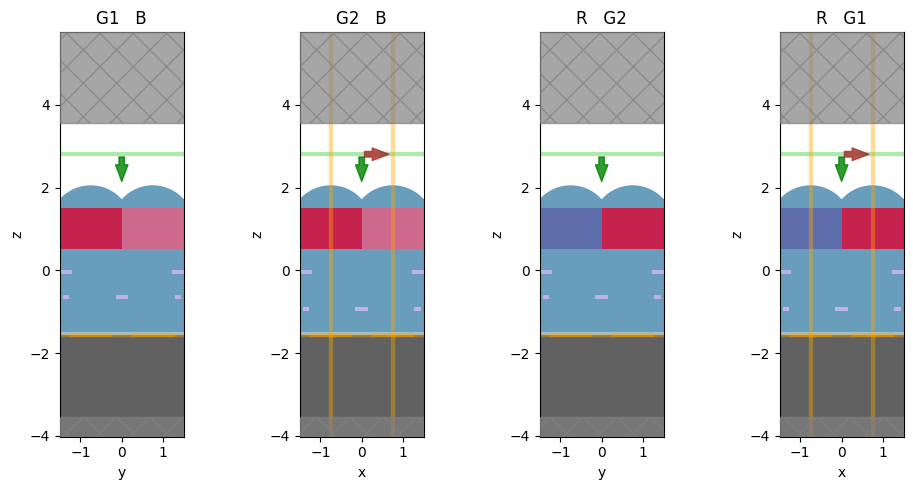

In [22]:
fig, ax = plt.subplots(1,4,figsize=(10,5),tight_layout=True)
sim.plot(x=width_len/1.99,ax=ax[0])
sim.plot(y=width_len/2,ax=ax[1])
sim.plot(x=-width_len/1.99,ax=ax[2])
sim.plot(y=-width_len/2,ax=ax[3])
ax[0].set_title("G1   B")
ax[1].set_title("G2   B")
ax[2].set_title("R   G2")
ax[3].set_title("R   G1")
plt.show()

## Simulation Run
Now, we can send the set up information to the cloud and run the simulation.

In [23]:
sim_data = web.run(sim, task_name="RGB CMOS Sensor")

11:56:58 UTC Created task 'RGB CMOS Sensor' with task_id                        
             'fdve-cc06c413-be9c-49bd-b23d-4fc94b3f2098' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=161929;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc06c413-be9c-49bd-b23d-4fc94b3f2098\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=945732;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc06c413-be9c-49bd-b23d-4fc94b3f2098\taskId]8;;\]8;id=161929;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc06c413-be9c-49bd-b23d-4fc94b3f2098\=]8;;\]8;id=141675;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc06c413-be9c-49bd-b23d-4fc94b3f2098\fdve]8;;\]8;id=161929;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc06c413-be9c-49bd-b23d-4fc94b3f2098\-cc06c413-be9]8;;\
             ]8;id=161929;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc06c413-be9c-49bd-b23d-4fc94b3f2098\c-49bd-b23d-4fc94b3f2098']8;;\.

Output()

11:57:06 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

11:57:11 UTC status = preprocess

11:57:13 UTC Maximum FlexCredit cost: 1.684. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

11:58:27 UTC early shutoff detected at 64%, exiting.

             status = postprocess

Output()

11:58:29 UTC status = success

11:58:30 UTC View simulation result at                                          
             ]8;id=84155;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc06c413-be9c-49bd-b23d-4fc94b3f2098\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=68374;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc06c413-be9c-49bd-b23d-4fc94b3f2098\taskId]8;;\]8;id=84155;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc06c413-be9c-49bd-b23d-4fc94b3f2098\=]8;;\]8;id=512821;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc06c413-be9c-49bd-b23d-4fc94b3f2098\fdve]8;;\]8;id=84155;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc06c413-be9c-49bd-b23d-4fc94b3f2098\-cc06c413-be9]8;;\
             ]8;id=84155;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc06c413-be9c-49bd-b23d-4fc94b3f2098\c-49bd-b23d-4fc94b3f2098']8;;\.

Output()

11:58:33 UTC loading simulation from simulation_data.hdf5

             WARNING: The medium associated with structures[5] has a frequency  
             range: (4.282749e+14, 7.466662e+14) (Hz) that does not fully cover 
             the frequencies contained in monitors[3]. This can cause           
             inaccuracies in the recorded results.                              

             WARNING: Suppressed 15 WARNING messages.                           

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

## Post Run Analysis
Once the simulation has completed, we can take a look at the simulation log and afterward analyze the results.

In [24]:
print(sim_data.log)

[11:57:10] WARNING: The medium associated with structures[5] has a frequency    
           range: (4.282749e+14, 7.466662e+14) (Hz) that does not fully cover   
           the frequencies contained in monitors[3]. This can cause inaccuracies
           in the recorded results.                                             
           USER: Simulation domain Nx, Ny, Nz: [390, 390, 429]                  
           USER: Applied symmetries: (0, 0, 0)                                  
           USER: Number of computational grid points: 6.5555e+07.               
           USER: Subpixel averaging method: SubpixelSpec(attrs={},              
           dielectric=PolarizedAveraging(attrs={}, type='PolarizedAveraging'),  
           metal=Staircasing(attrs={}, type='Staircasing'),                     
           pec=PECConformal(attrs={}, type='PECConformal',                      
           timestep_reduction=0.3), type='SubpixelSpec')                        
           USER: Number of t

### Field profile
Let's visualize the field profile at the central wavelength of each RBG color. First, we illustrate the propagation of the light by showing the fields in the `yz` cross-section.

In the figure below, the cross-section passes through the G1 and B filters. As you can see, the red light is largely absorbed, while the blue and the green light pass through the corresponding filters.

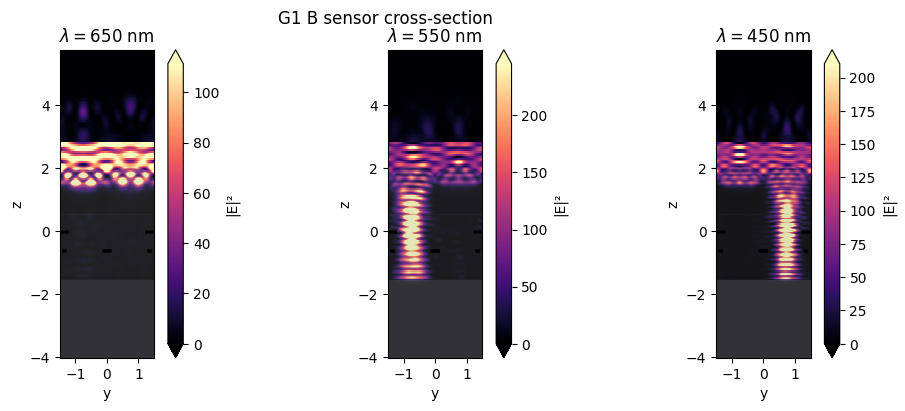

In [25]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))
sim_data.plot_field('field_yz_BG', 'E', val='abs^2', ax=ax[0], f=td.C_0/lam_red)
sim_data.plot_field('field_yz_BG', 'E', val='abs^2', ax=ax[1], f=td.C_0/lam_green)
sim_data.plot_field('field_yz_BG', 'E', val='abs^2', ax=ax[2], f=td.C_0/lam_blue)
ax[0].set_title('$\lambda = 650$ nm')
ax[1].set_title('$\lambda = 550$ nm')
ax[2].set_title('$\lambda = 450$ nm')
fig.suptitle('G1 B sensor cross-section')
plt.show()

Similarly, in the figure below, the cross-section passes through the R and G2 filters. Consequently, the blue light is largely absorbed, while the red and the green light pass through the corresponding filters.

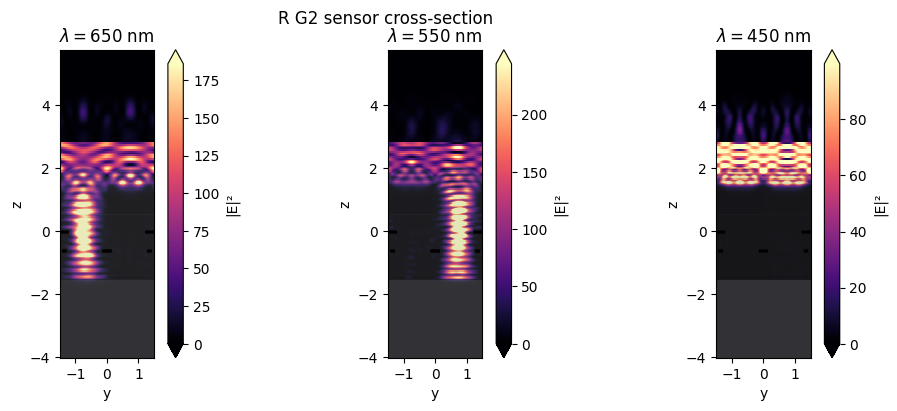

In [26]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))
sim_data.plot_field('field_yz_GR', 'E', val='abs^2', ax=ax[0], f=td.C_0/lam_red)
sim_data.plot_field('field_yz_GR', 'E', val='abs^2', ax=ax[1], f=td.C_0/lam_green)
sim_data.plot_field('field_yz_GR', 'E', val='abs^2', ax=ax[2], f=td.C_0/lam_blue)
ax[0].set_title('$\lambda = 650$ nm')
ax[1].set_title('$\lambda = 550$ nm')
ax[2].set_title('$\lambda = 450$ nm')
fig.suptitle('R G2 sensor cross-section')
plt.show()

Finally, let's visualize the field on the top of the silicon photodetector layer. The figure below shows the fields in the xy cross-section. Recall that the red filter takes place in the lower left part of the cross-section, the blue in the upper right, and the green in the lower right and upper left. As expected, the field at each color is concentrated in the corresponding regions.

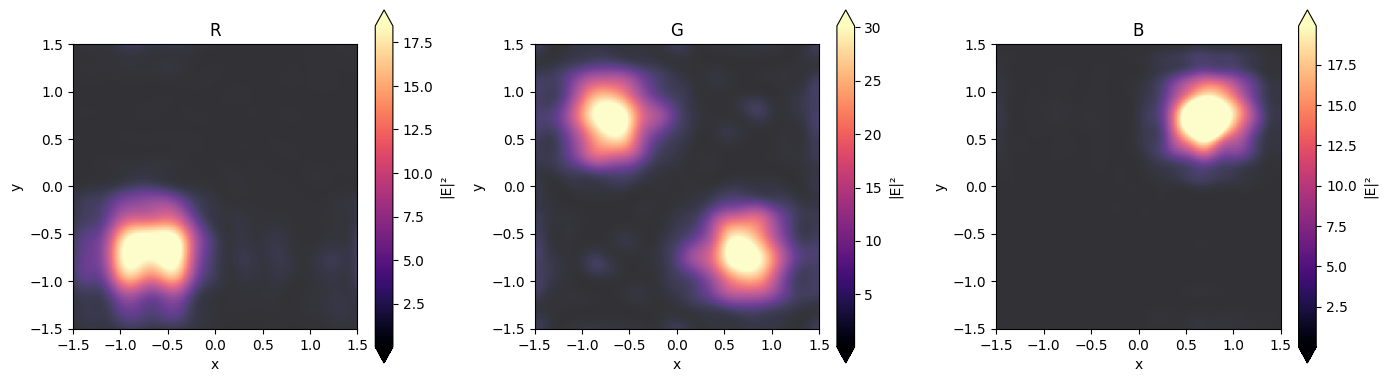

In [27]:
fig, ax = plt.subplots(1,3, tight_layout=True, figsize=(14, 4))
sim_data.plot_field('field_xy_silicon', 'E', val='abs^2', ax=ax[0], f=td.C_0/lam_red)
sim_data.plot_field('field_xy_silicon', 'E', val='abs^2', ax=ax[1], f=td.C_0/lam_green)
sim_data.plot_field('field_xy_silicon', 'E', val='abs^2', ax=ax[2], f=td.C_0/lam_blue)
ax[0].set_title('R')
ax[1].set_title('G')
ax[2].set_title('B')
plt.show()

### Optical efficiency

The optical efficiency ($OE$) is defined as the ratio of the power flux routed to the photodetector of a particular color channel ($P_{CH}$) to the power flux incident on the entire device ($P_{0}$). 

$$
OE = \frac{P_{CH}}{P_{0}}
$$

In the figure below, we show the optical efficiency as a function of wavelengths for each color channel. The central wavelength of each color is highlighted with the dashed lines. The flux is automatically normalized by the power flux incident on the entire device. Thus, each flux monitor contains the optical efficiency as a function of frequency.

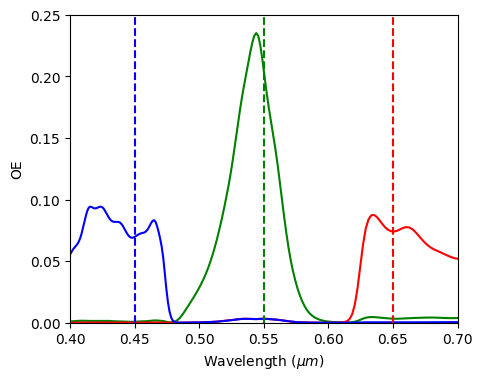

In [28]:
flux_red = -sim_data['flux_si_red'].flux
flux_blue = -sim_data['flux_si_blue'].flux
flux_green1 = -sim_data['flux_si_green1'].flux
flux_green2 = -sim_data['flux_si_green2'].flux
flux_green = flux_green1 + flux_green2

fig, ax = plt.subplots(1, figsize=(5, 4))
lambda_flux = td.C_0/monitor_flux_freqs
ax.plot(lambda_flux, flux_green,'g')
ax.plot(lambda_flux, flux_red,'r')
ax.plot(lambda_flux, flux_blue,'b')
ax.set_xlabel('Wavelength ($\mu m$)')
ax.set_ylabel('OE')
ax.set_xlim(0.4, 0.7)
ax.set_ylim(0, 0.25)

ax.vlines(0.45, 0, 0.25, linestyles='dashed', colors='b')
ax.vlines(0.55, 0, 0.25, linestyles='dashed', colors='g')
ax.vlines(0.65, 0, 0.25, linestyles='dashed', colors='r')
plt.show()

The above figure shows that the optical efficiency at the central wavelength allows the distinction of colors. However, there is significant room for improvement.